<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/home/octo/code/ENTER/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff6991585f0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

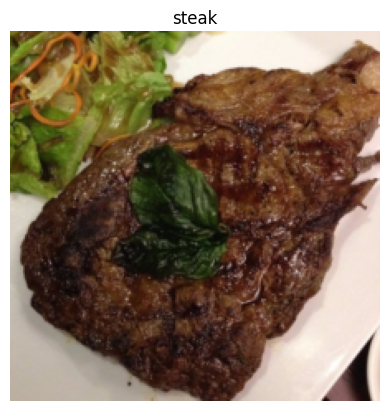

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [10]:
height, width = image.shape[-2:]
patch_size = 16

num_patches = height * width // patch_size

num_patches

3136

In [11]:
# TODO: your code


class PatchEmbedding(nn.Module):
    """
    Module block to process a batch of images of 
    shape [batch_size, num_channels, height, width]
    -> [batch_size, num_patches, patch_size ** 2 * num_channels]
    """
    def __init__(self, color_channel=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=color_channel,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    
    def forward(self, x):
        # Input is a batch of images in shape -> [batch_size, num_channels, height, width]
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Image resolution ({image_resolution}) should be divisible by patch size ({patch_size})"
        return self.flatten(self.conv(x)).permute(0, 2, 1) # Shape [batch_size, num_patches, patch_size ** 2 * num_channels]
    



In [12]:
test_tensor = torch.randn(size=[1, 3, 224, 224])
test_pe = PatchEmbedding()
test_output = test_pe(test_tensor)

test_output.shape

torch.Size([1, 196, 768])

In [13]:
class ViT(nn.Module):
    def __init__(self,
                 num_layers=12,
                 patch_size=16,
                 embedding_dim=768,
                 MLP_size=3072,
                 num_heads=12,
                 num_classes=3
                 ):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size=patch_size,
                                          embedding_dim=embedding_dim)
        self.encoder_block = torch.nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                              nhead=num_heads,
                                                              dim_feedforward=MLP_size,
                                                              batch_first=True,
                                                              activation="gelu",
                                                              dropout=0.1,
                                                              norm_first=True)
        self.encoder = torch.nn.TransformerEncoder(self.encoder_block,
                                                   num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [14]:
test_tensor = torch.randn(size=[1, 3, 224, 224])
test_pe = ViT()
test_output = test_pe(test_tensor)

test_output.shape

/home/octo/code/ENTER/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([1, 3])

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [15]:
%%writefile vit.py
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    """
    Module block to process a batch of images of 
    shape [batch_size, num_channels, height, width]
    -> [batch_size, num_patches, patch_size ** 2 * num_channels]
    """
    def __init__(self, color_channel=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=color_channel,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    
    def forward(self, x):
        # Input is a batch of images in shape -> [batch_size, num_channels, height, width]
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Image resolution ({image_resolution}) should be divisible by patch size ({self.patch_size})"
        return self.flatten(self.patcher(x)).permute(0, 2, 1) # Shape [batch_size, num_patches, patch_size ** 2 * num_channels]


class ViT(nn.Module):
    def __init__(self,
                 num_layers=12,
                 patch_size=16,
                 embedding_dim=768,
                 MLP_size=3072,
                 num_heads=12,
                 num_classes=3
                 ):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size=patch_size,
                                          embedding_dim=embedding_dim)
        self.encoder_block = torch.nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                              nhead=num_heads,
                                                              dim_feedforward=MLP_size,
                                                              batch_first=True,
                                                              activation="gelu",
                                                              dropout=0.1,
                                                              norm_first=True)
        self.encoder = torch.nn.TransformerEncoder(self.encoder_block,
                                                   num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.classifier(x[:, 0])
        return x

Overwriting vit.py


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [16]:
# Get data and create dataloader
from pathlib import Path
import os
# from vit import ViT

data_path = Path("../../data")
image_path_20 = data_path / "pizza_steak_sushi_20_percent"
train_dir_20 = image_path_20 / "train"
test_dir_20 = image_path_20 / "test"

train_dataloader_20, test_dataloader_20, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20,
    test_dir=test_dir_20,
    transform=manual_transforms,
    batch_size=32,
    num_workers=os.cpu_count()
)

In [17]:
# DONE: your code
import torch.nn as nn
import torch.optim.optimizer
from vit import ViT

set_seeds()

model_0 = ViT(patch_size=16).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

model_0_result_20_percent = engine.train(model=model_0,
                                         train_dataloader=train_dataloader_20,
                                         test_dataloader=test_dataloader_20,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=10,
                                         device=device)

 10%|█         | 1/10 [00:09<01:25,  9.53s/it]

Epoch: 1 | train_loss: 2.3525 | train_acc: 0.2958 | test_loss: 4.2137 | test_acc: 0.3500


 20%|██        | 2/10 [00:18<01:14,  9.28s/it]

Epoch: 2 | train_loss: 1.7976 | train_acc: 0.3354 | test_loss: 1.2771 | test_acc: 0.3625


 30%|███       | 3/10 [00:27<01:04,  9.18s/it]

Epoch: 3 | train_loss: 1.1818 | train_acc: 0.3583 | test_loss: 1.6600 | test_acc: 0.2875


 40%|████      | 4/10 [00:36<00:54,  9.13s/it]

Epoch: 4 | train_loss: 1.2203 | train_acc: 0.3104 | test_loss: 1.1995 | test_acc: 0.2875


 50%|█████     | 5/10 [00:45<00:45,  9.04s/it]

Epoch: 5 | train_loss: 1.1430 | train_acc: 0.3438 | test_loss: 1.2040 | test_acc: 0.3500


 60%|██████    | 6/10 [00:54<00:36,  9.00s/it]

Epoch: 6 | train_loss: 1.1417 | train_acc: 0.3521 | test_loss: 1.2746 | test_acc: 0.3443


 70%|███████   | 7/10 [01:03<00:26,  8.98s/it]

Epoch: 7 | train_loss: 1.1145 | train_acc: 0.4062 | test_loss: 1.1653 | test_acc: 0.2835


 80%|████████  | 8/10 [01:12<00:17,  8.94s/it]

Epoch: 8 | train_loss: 1.1183 | train_acc: 0.3542 | test_loss: 1.1975 | test_acc: 0.2875


 90%|█████████ | 9/10 [01:21<00:08,  8.93s/it]

Epoch: 9 | train_loss: 1.1306 | train_acc: 0.3500 | test_loss: 1.3059 | test_acc: 0.3500


100%|██████████| 10/10 [01:30<00:00,  9.02s/it]

Epoch: 10 | train_loss: 1.2434 | train_acc: 0.3208 | test_loss: 1.1609 | test_acc: 0.2653


## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [18]:
# DONE: your code
from going_modular.going_modular import data_setup

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
model_pretrained = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

pretrained_transform = pretrained_vit_weights.transforms()

for param in model_pretrained.parameters():
    param.requires_grad = False


train_dataloader_pre, test_dataloader_pre, class_names =  data_setup.create_dataloaders(
    train_dir=train_dir_20,
    test_dir=test_dir_20,
    transform=pretrained_transform,
    batch_size=32,
    num_workers=os.cpu_count()
)

set_seeds()
model_pretrained.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Train the pretrained vit-b16 model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_pretrained.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

model_pretrained_results = engine.train(model=model_pretrained, 
                                        train_dataloader=train_dataloader_pre,
                                        test_dataloader=test_dataloader_pre,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn, 
                                        epochs=10,
                                        device=device)

 10%|█         | 1/10 [00:13<01:58, 13.14s/it]

Epoch: 1 | train_loss: 0.1478 | train_acc: 0.9437 | test_loss: 0.0040 | test_acc: 1.0000


 20%|██        | 2/10 [00:26<01:45, 13.16s/it]

Epoch: 2 | train_loss: 0.0224 | train_acc: 0.9938 | test_loss: 0.0041 | test_acc: 1.0000


 30%|███       | 3/10 [00:39<01:31, 13.10s/it]

Epoch: 3 | train_loss: 0.0242 | train_acc: 0.9979 | test_loss: 0.0117 | test_acc: 1.0000


 40%|████      | 4/10 [00:52<01:18, 13.08s/it]

Epoch: 4 | train_loss: 0.0473 | train_acc: 0.9938 | test_loss: 0.0110 | test_acc: 1.0000


 50%|█████     | 5/10 [01:05<01:05, 13.03s/it]

Epoch: 5 | train_loss: 0.0295 | train_acc: 0.9917 | test_loss: 0.0048 | test_acc: 1.0000


 60%|██████    | 6/10 [01:18<00:52, 13.01s/it]

Epoch: 6 | train_loss: 0.0139 | train_acc: 1.0000 | test_loss: 0.0057 | test_acc: 1.0000


 70%|███████   | 7/10 [01:31<00:39, 13.03s/it]

Epoch: 7 | train_loss: 0.0304 | train_acc: 0.9979 | test_loss: 0.0113 | test_acc: 1.0000


 80%|████████  | 8/10 [01:44<00:26, 13.07s/it]

Epoch: 8 | train_loss: 0.0358 | train_acc: 0.9938 | test_loss: 0.0313 | test_acc: 0.9909


 90%|█████████ | 9/10 [01:57<00:13, 13.09s/it]

Epoch: 9 | train_loss: 0.0203 | train_acc: 0.9958 | test_loss: 0.0096 | test_acc: 1.0000


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]

Epoch: 10 | train_loss: 0.0173 | train_acc: 1.0000 | test_loss: 0.0131 | test_acc: 1.0000


# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

In [19]:
# TODO: your explanations of the above terms

# - ImageNet-21k dataset is larger and more diverse dataset than common ImageNet-1k

In [20]:
try:
    import timm
except:
    !pip install timm
    import timm

model_pre_ImgNet21k = timm.create_model('vit_base_patch16_224_miil_in21k',
                                        pretrained=False)


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/77/f7/144d69d921fba82baa8498e279d782a12a13694f45ff74d1777bc3231ffe/timm-1.0.11-py3-none-any.whl (2.3 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/60/bf/cea0b9720c32fa01b0c4ec4b16b9f4ae34ca106b202ebbae9f03ab98cd8f/huggingface_hub-0.26.2-py3-none-any.whl (447 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 869.0 kB/s eta 0:00:00a 0:00:01


/home/octo/code/ENTER/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_miil_in21k to current vit_base_patch16_224_miil.in21k.
  model = create_fn(


In [29]:
# DONE: your code
from pathlib import Path
from going_modular.going_modular import data_setup

vit_img21k_weights_path = Path("models/vit_base_patch16_224_miil_21k.pth")

model_pre_ImgNet21k = timm.create_model(model_name='vit_base_patch16_224_miil_in21k',
                                        pretrained=False,
                                        checkpoint_path=vit_img21k_weights_path)

for param in model_pre_ImgNet21k.parameters():
    param.requires_grad = False

model_pre_ImgNet21k.head = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

summary(model_pre_ImgNet21k,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)    [32, 3, 224, 224]    [32, 3]              152,064              Partial
├─PatchEmbed (patch_embed)               [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    └─Conv2d (proj)                     [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    └─Identity (norm)                   [32, 196, 768]       [32, 196, 768]       --                   --
├─Dropout (pos_drop)                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (patch_drop)                  [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (norm_pre)                    [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (blocks)                    [32, 197, 768]       [32, 197, 768]       --                   False
│    └─Block (0)

In [31]:
# Get transform used in ViT-B16-ImageNet21k
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
config = resolve_data_config({}, model=model_pre_ImgNet21k)
pretrained_transform_21k = create_transform(**config)

In [32]:



train_dataloader_pre, test_dataloader_pre, class_names =  data_setup.create_dataloaders(
    train_dir=train_dir_20,
    test_dir=test_dir_20,
    transform=pretrained_transform_21k,
    batch_size=32,
    num_workers=os.cpu_count()
)

set_seeds()


# Train the pretrained vit-b16 model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_pre_ImgNet21k.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

model_pretrained_results = engine.train(model=model_pre_ImgNet21k, 
                                        train_dataloader=train_dataloader_pre,
                                        test_dataloader=test_dataloader_pre,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn, 
                                        epochs=10,
                                        device=device)

 10%|█         | 1/10 [00:04<00:44,  4.93s/it]

Epoch: 1 | train_loss: 0.3620 | train_acc: 0.8750 | test_loss: 0.0165 | test_acc: 0.9875


 20%|██        | 2/10 [00:09<00:39,  4.93s/it]

Epoch: 2 | train_loss: 0.0594 | train_acc: 0.9833 | test_loss: 0.0191 | test_acc: 0.9938


 30%|███       | 3/10 [00:14<00:34,  4.93s/it]

Epoch: 3 | train_loss: 0.0279 | train_acc: 0.9917 | test_loss: 0.0109 | test_acc: 0.9938


 40%|████      | 4/10 [00:19<00:29,  4.94s/it]

Epoch: 4 | train_loss: 0.0218 | train_acc: 0.9958 | test_loss: 0.0153 | test_acc: 1.0000


 50%|█████     | 5/10 [00:24<00:23,  4.70s/it]

Epoch: 5 | train_loss: 0.0248 | train_acc: 0.9979 | test_loss: 0.0224 | test_acc: 0.9938


 60%|██████    | 6/10 [00:28<00:18,  4.57s/it]

Epoch: 6 | train_loss: 0.0316 | train_acc: 1.0000 | test_loss: 0.0205 | test_acc: 1.0000


 70%|███████   | 7/10 [00:33<00:13,  4.66s/it]

Epoch: 7 | train_loss: 0.0380 | train_acc: 0.9979 | test_loss: 0.0177 | test_acc: 0.9938


 80%|████████  | 8/10 [00:38<00:09,  4.75s/it]

Epoch: 8 | train_loss: 0.0426 | train_acc: 1.0000 | test_loss: 0.0217 | test_acc: 1.0000


 90%|█████████ | 9/10 [00:43<00:04,  4.81s/it]

Epoch: 9 | train_loss: 0.0580 | train_acc: 0.9792 | test_loss: 0.0542 | test_acc: 0.9875


100%|██████████| 10/10 [00:47<00:00,  4.80s/it]

Epoch: 10 | train_loss: 0.0437 | train_acc: 0.9896 | test_loss: 0.0173 | test_acc: 1.0000
